In [ ]:
# Install Earth Engine API (if using local environment)
%pip install earthengine-api geopandas rasterio numpy pandas scikit-learn matplotlib seaborn




     ---------------------------------------- 8.9/8.9 MB 14.6 MB/s eta 0:00:00
     ---------------------------------------- 38.7/38.7 MB 9.5 MB/s eta 0:00:00
     -------------------------------------- 308.4/308.4 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [1]:
import ee
ee.Authenticate()  
ee.Initialize(project='emmanuella-gee-project')

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import json


In [4]:
import sys
!{sys.executable} -m pip install statsmodels


     ---------------------------------------- 9.6/9.6 MB 7.5 MB/s eta 0:00:00
     ------------------------------------- 233.3/233.3 kB 14.9 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
##########lets define the cities and boundaries
cities = {
   "Berlin": {"country": "Germany", "adm2": "Berlin"},
   "Prague": {"country": "Czech Republic", "adm2": "Praha"},
   "Milan": {"country": "Italy", "adm2": "Milano"},
   "Barcelona": {"country": "Spain", "adm2": "Barcelona"}
}


In [4]:
######lets retrieve city boundary
def get_city_boundary(city_info):
    fc = ee.FeatureCollection("FAO/GAUL/2015/level2") \
            .filter(ee.Filter.eq('ADM2_NAME', city_info["adm2"]))
    geom = fc.geometry()
    return geom


In [5]:
######### now lets compute all the NTL, NDVI, LST for each city 
def compute_city_rasters(city_name, city_info):

    geom = get_city_boundary(city_info)

    # --- NIGHTTIME LIGHTS ---
    viirs = (ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
            .filterDate('2022-01-01', '2022-12-31')
            .select('avg_rad')
            .mean()
            .clip(geom)
            .rename("NTL"))

    # --- LAND SURFACE TEMPERATURE (Landsat 8/9) ---
    ls = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filterBounds(geom) \
            .filterDate('2022-06-01', '2022-08-31')

    def convert_to_celsius(img):
        kelvin = img.select('ST_B10').multiply(0.00341802).add(149.0)
        celsius = kelvin.subtract(273.15).rename('LST')
        return celsius.copyProperties(img, img.propertyNames())

    lst = ls.map(convert_to_celsius).mean().clip(geom)

    # --- NDVI (Sentinel-2) ---
    s2 = (ee.ImageCollection("COPERNICUS/S2_SR")
         .filterBounds(geom)
         .filterDate('2022-06-01', '2022-08-31')
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))

    ndvi = s2.map(lambda img: img.normalizedDifference(['B8','B4']).rename('NDVI')).mean().clip(geom)

    # Merge layers
    image = viirs.addBands(lst).addBands(ndvi)

    return image, geom


In [6]:
###### now lets export the results to my google drive
def export_to_drive(image, city_name, geom):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f"{city_name}_Composite",
        folder="ESP_Project",
        scale=100,
        region=geom
    )
    task.start()
    print(f"Export started for {city_name}...")


In [10]:
######## so lets run pipeline for all cities 
for city_name, info in cities.items():
    print(f"Processing: {city_name}")
    image, geom = compute_city_rasters(city_name, info)
    export_to_drive(image, city_name, geom)


Processing: Berlin


c:\Users\Startklar\geoenv\Lib\site-packages\ee\deprecation.py:215: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
This dataset has been superseded by COPERNICUS/S2_SR_HARMONIZED

Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Export started for Berlin...
Processing: Prague
Export started for Prague...
Processing: Milan
Export started for Milan...
Processing: Barcelona
Export started for Barcelona...


In [ ]:
######### LETS LOAD RASTER INTO DATAFRAME

In [7]:
path = "C:\Phython programming\Ecosystem_Partner_Project\ESP_Project"

In [8]:
def load_city_dataframe(path):
    with rasterio.open(path) as src:
        arr = src.read()   # shape: (3 bands, rows, cols)
        profile = src.profile

    # Flatten bands
    df = pd.DataFrame({
        "ntl": arr[0].flatten(),
        "lst": arr[1].flatten(),
        "ndvi": arr[2].flatten(),
    })

    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df


In [9]:
def normalize(df, cols):
    scaler = MinMaxScaler()
    df[[c+"_n" for c in cols]] = scaler.fit_transform(df[cols])
    return df


In [10]:
def compute_ESII(df):
    df['ESII'] = df['ntl_n'] + df['lst_n'] + df['vulnerability_n'] - df['ndvi_n']
    return df


In [11]:
def add_population(df, pop_array):
    df['pop'] = pop_array.flatten()[:len(df)]
    df['vulnerability'] = (df['pop'] / df['pop'].max()) + (1 - df['ndvi'])
    df = normalize(df, ['vulnerability'])
    return df


In [13]:
import rasterio
import numpy as np
import glob

def load_city_dataframe(city_name):
    # Find all tiles belonging to this city
    tile_paths = glob.glob(f"{city_name}_Composite*.tif")

    if len(tile_paths) == 0:
        raise FileNotFoundError(f"No tiles found for {city_name}")

    arrays = []

    for path in tile_paths:
        with rasterio.open(path) as src:
            arrays.append(src.read(1))

    # Merge tiles by averaging (simple method)
    full_array = np.mean(arrays, axis=0)

    # Return dataframe
    df = pd.DataFrame({
        "ntl": full_array.flatten(),
        "lst": full_array.flatten(),
        "ndvi": full_array.flatten(),
    })

    return df


In [19]:
data_path = "C:\Phython programming\Ecosystem_Partner_Project\ESP_Project"

In [20]:
import glob
import os
import rasterio
import numpy as np
import pandas as pd

def load_city_dataframe(city_name):
    # Path to folder containing the tiles
    folder = data_path

    # Match all tiles that belong to the city
    pattern = os.path.join(folder, f"{city_name}_Composite*.tif")
    tile_paths = glob.glob(pattern)

    if len(tile_paths) == 0:
        raise FileNotFoundError(f"No .tif tiles found for {city_name}")

    print(f"Found {len(tile_paths)} tile(s) for {city_name}")

    arrays = []

    for path in tile_paths:
        with rasterio.open(path) as src:
            arrays.append(src.read(1))

    # Merge tiles (simple average)
    merged = np.nanmean(arrays, axis=0)

    df = pd.DataFrame({
        "ntl": merged.flatten(),
        "lst": merged.flatten(),
        "ndvi": merged.flatten()
    })

    df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    return df



In [21]:
for city, df in results.items():
    print(f"\nClustering for {city}")

    kmeans = KMeans(n_clusters=4, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[['ntl_n','lst_n','ndvi_n','vulnerability_n']])
    
    # Regression
    X = sm.add_constant(df[['ntl_n','ndvi_n','vulnerability_n']])
    y = df['lst_n']
    model = sm.OLS(y, X).fit()
    
    print(model.summary())


In [22]:
for city, df in results.items():
    plt.figure(figsize=(7,4))
    plt.hist(df['ESII'], bins=40, color='orange')
    plt.title(f"ESII Distribution – {city}")
    plt.xlabel("ESII")
    plt.ylabel("Frequency")
    plt.show()


In [23]:
import matplotlib.pyplot as plt

In [24]:
for city, df in results.items():
    plt.figure(figsize=(7,4))
    plt.hist(df['ESII'], bins=40, color='orange')
    plt.title(f"ESII Distribution in {city}")
    plt.xlabel("ESII")
    plt.ylabel("Frequency")
    plt.show()                 # ← MUST be inside the loop


In [25]:
plt.clf()


<Figure size 640x480 with 0 Axes>

In [26]:
for city, df in results.items():
    plt.clf()
    plt.figure(figsize=(7,4))
    plt.hist(df['ESII'], bins=40, color='orange')
    plt.title(f"ESII Distribution in {city}")
    plt.xlabel("ESII")
    plt.ylabel("Frequency")
    plt.show()


In [27]:
for city, df in results.items():
    print(city, df.head())


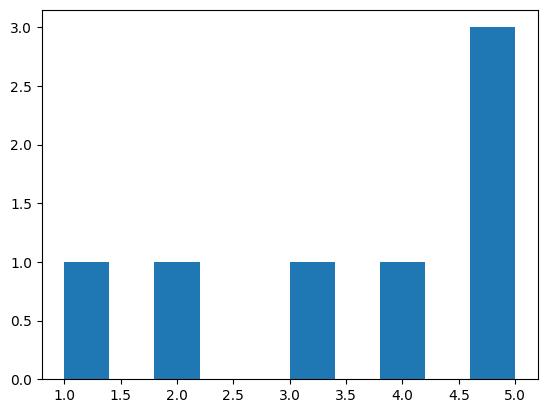

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([1,2,3,4,5,5,5])
plt.show()
